# These results are worse than previous optuna attempts. Therefore we should proceed with previous parameters (323) and assess for overfitting
### Best parameters found by Optuna:
##### n_estimators = 323
##### max_depth = 8
##### min_samples_split = 2
##### min_samples_leaf = 1

In [1]:
#import Regression_variables from same directory
from regression_variable_morgan_comparison import *

# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

2024-08-04 23:34:10.498031: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



Assign cluster ID

Assign cluster ID


  0%|          | 0/595 [00:00<?, ?it/s][23:36:10] DEPRECATION WARNING: please use MorganGenerator
[23:36:10] DEPRECATION WARNING: please use MorganGenerator
[23:36:10] DEPRECATION WARNING: please use MorganGenerator
[23:36:10] DEPRECATION WARNING: please use MorganGenerator
[23:36:10] DEPRECATION WARNING: please use MorganGenerator
[23:36:10] DEPRECATION WARNING: please use MorganGenerator
[23:36:10] DEPRECATION WARNING: please use MorganGenerator
[23:36:10] DEPRECATION WARNING: please use MorganGenerator
[23:36:10] DEPRECATION WARNING: please use MorganGenerator
[23:36:10] DEPRECATION WARNING: please use MorganGenerator
[23:36:10] DEPRECATION WARNING: please use MorganGenerator
[23:36:10] DEPRECATION WARNING: please use MorganGenerator
[23:36:10] DEPRECATION WARNING: please use MorganGenerator
[23:36:10] DEPRECATION WARNING: please use MorganGenerator
[23:36:10] DEPRECATION WARNING: please use MorganGenerator
[23:36:10] DEPRECATION WARNING: please use MorganGenerator
[23:36:10] DEPREC

# Creating Random Forests for Random, Strat, Hierarchical clustering, UMAP noise and UMAP furthest cluster splits

In [2]:
rfr_rand_MACCS = RandomForestRegressor(random_state=SEED)
rfr_rand_m2 = RandomForestRegressor(random_state=SEED)
rfr_strat = RandomForestRegressor(random_state=SEED)
rfr_hi = RandomForestRegressor(random_state=SEED)
rfr_noise = RandomForestRegressor(random_state=SEED)
rfr_fur = RandomForestRegressor(random_state=SEED)

rfr_rand_MACCS.fit(np.array(list((x_train_rand))).astype(float), y_train_rand)
rfr_rand_m2.fit(np.array(list((x_train_rand_m2))).astype(float), y_train_rand_m2)
rfr_strat.fit(np.array(list((x_train_strat))).astype(float), y_train_strat)
rfr_hi.fit(np.array(list((x_train_hi))).astype(float), y_train_hi)
rfr_noise.fit(np.array(list((x_train_noise))).astype(float), y_train_noise)
rfr_fur.fit(np.array(list((x_train_fur))).astype(float), y_train_fur)

y_pred_rfr_rand_MACCS = rfr_rand_MACCS.predict(np.array(list((x_test_rand))).astype(float))
y_pred_rfr_rand_m2 = rfr_rand_m2.predict(np.array(list((x_test_rand_m2))).astype(float))
y_pred_rfr_strat = rfr_strat.predict(np.array(list((x_test_strat))).astype(float))
y_pred_rfr_hi = rfr_hi.predict(np.array(list((x_test_hi))).astype(float))
y_pred_rfr_noise = rfr_noise.predict(np.array(list((x_test_noise))).astype(float))
y_pred_rfr_fur = rfr_fur.predict(np.array(list((x_test_fur))).astype(float))

mae_rfr_rand_m2 = mean_absolute_error(y_test_rand_m2, y_pred_rfr_rand_m2)
mse_rfr_rand_m2 = mean_squared_error(y_test_rand_m2, y_pred_rfr_rand_m2)
r2_rfr_rand_m2 = r2_score(y_test_rand_m2, y_pred_rfr_rand_m2)

mae_rfr_rand_MACCS = mean_absolute_error(y_test_rand, y_pred_rfr_rand_MACCS)
mse_rfr_rand_MACCS = mean_squared_error(y_test_rand, y_pred_rfr_rand_MACCS)
r2_rfr_rand_MACCS = r2_score(y_test_rand, y_pred_rfr_rand_MACCS)

mae_rfr_strat = mean_absolute_error(y_test_strat, y_pred_rfr_strat)
mse_rfr_strat = mean_squared_error(y_test_strat, y_pred_rfr_strat)
r2_rfr_strat = r2_score(y_test_strat, y_pred_rfr_strat)

mae_rfr_hi = mean_absolute_error(y_test_hi, y_pred_rfr_hi)
mse_rfr_hi = mean_squared_error(y_test_hi, y_pred_rfr_hi)
r2_rfr_hi = r2_score(y_test_hi, y_pred_rfr_hi)

mae_rfr_noise = mean_absolute_error(y_test_noise, y_pred_rfr_noise)
mse_rfr_noise = mean_squared_error(y_test_noise, y_pred_rfr_noise)
r2_rfr_noise = r2_score(y_test_noise, y_pred_rfr_noise)

mae_rfr_fur = mean_absolute_error(y_test_fur, y_pred_rfr_fur)
mse_rfr_fur = mean_squared_error(y_test_fur, y_pred_rfr_fur)
r2_rfr_fur = r2_score(y_test_fur, y_pred_rfr_fur)

In [3]:
#Create a table that shows the performance of the random forest regressor on the different splits displaying mae, mse and r2 values
#display and save variable values to 3sf

split_scores_rfr_initial = {'Split': ['Random MACCS', 'Random Morgan2', 'Stratified pIC50', 'Hierarchical Clustering', 'UMAP Noise', 'UMAP Furthest Cluster'],
        'MAE': [mae_rfr_rand_MACCS, mae_rfr_rand_m2, mae_rfr_strat, mae_rfr_hi, mae_rfr_noise, mae_rfr_fur],
        'MSE': [mse_rfr_rand_MACCS, mse_rfr_rand_m2, mse_rfr_strat, mse_rfr_hi, mse_rfr_noise, mse_rfr_fur],
        'R2': [r2_rfr_rand_MACCS, r2_rfr_rand_m2, r2_rfr_strat, r2_rfr_hi, r2_rfr_noise, r2_rfr_fur]}

split_scores_rfr_initial_df = pd.DataFrame(split_scores_rfr_initial)
split_scores_rfr_initial_df.set_index("Split", inplace=True)
# Round the values to 3 significant figures
split_scores_rfr_initial_df = split_scores_rfr_initial_df.applymap(lambda x: round(x, 3))
#save df to csv in data file
split_scores_rfr_initial_df.to_csv(DATA / "split_scores_rfr_initial.csv")
print(split_scores_rfr_initial_df)

                           MAE    MSE     R2
Split                                       
Random MACCS             0.383  0.309  0.580
Random Morgan2           0.328  0.252  0.657
Stratified pIC50         0.462  0.423  0.517
Hierarchical Clustering  0.675  0.705  0.324
UMAP Noise               0.716  0.705  0.007
UMAP Furthest Cluster    0.708  0.696  0.061


# Optuna

### With a saving feature

In [4]:
study_name_TPE_MACCS = "random_forest_study_TPE"  # Unique identifier of the study
storage_name_TPE_MACCS = f"sqlite:///example_TPE.db"  # SQLite database URL

study_rand_TPE_MACCS = optuna.create_study(study_name=study_name_TPE_MACCS, storage=storage_name_TPE_MACCS, load_if_exists=True)

[I 2024-08-04 23:36:52,256] Using an existing study with name 'random_forest_study_TPE' instead of creating a new one.


In [5]:
def objective(trial, X_train, y_train):
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 2, 16)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    return score

In [6]:
def save_best_trial(study, trial):
    if study.best_trial == trial:
        print(f"New best trial found: {trial.number}")
        print(f"Value: {trial.value}")
        print(f"Params: {trial.params}")


In [7]:
# Create study without saving best trials

# study_rand = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED))
# study_strat = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED))
# study_hi = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED))
# study_noise = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED))
# study_fur = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED))

#set the sampler of this study to genetic aglorithm
# study_rand_TPE = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))


In [8]:
# # study_rand.optimize(lambda trial: objective(trial, np.array(list((x_train_rand))).astype(float), y_train_rand), n_trials=1000, show_progress_bar=True)

# # Optimize the study with a callback to save the best trial
# study_rand.optimize(lambda trial: objective(trial, np.array(list(x_train_rand)).astype(float), y_train_rand), 
#                     n_trials=1000, 
#                     show_progress_bar=True, 
#                     callbacks=[save_best_trial])


In [9]:
study_rand_TPE_MACCS.optimize(lambda trial: objective(trial, np.array(list(x_train_rand)).astype(float), y_train_rand), 
                    n_trials=1500, 
                    show_progress_bar=True, 
                    callbacks=[save_best_trial])

  0%|          | 0/1500 [00:00<?, ?it/s]

[I 2024-08-04 23:37:07,355] Trial 4805 finished with value: -0.7027168627802116 and parameters: {'n_estimators': 89, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 4412 with value: -0.7219537167144833.
[I 2024-08-04 23:37:17,391] Trial 4806 finished with value: -0.6989965478658313 and parameters: {'n_estimators': 873, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 4412 with value: -0.7219537167144833.
[I 2024-08-04 23:37:20,427] Trial 4807 finished with value: -0.7015042077955672 and parameters: {'n_estimators': 93, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 4412 with value: -0.7219537167144833.
[I 2024-08-04 23:37:22,411] Trial 4808 finished with value: -0.6143599604570278 and parameters: {'n_estimators': 90, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 4412 with value: -0.7219537167144833.
[I 2024-08-04 23:37:29,452] Trial 4809 finished with value: -0.7012

In [10]:
# study_rand_TPE_m2.optimize(lambda trial: objective(trial, np.array(list(x_train_rand_m2)).astype(float), y_train_rand_m2), 
#                     n_trials=1500, 
#                     show_progress_bar=True, 
#                     callbacks=[save_best_trial])

In [11]:
# study_name_fur_TPE = "random_forest_study_fur_TPE"  # Unique identifier of the study
# storage_name_fur_TPE = f"sqlite:///example_fur_TPE.db"  # SQLite database URL

# study_fur_TPE = optuna.create_study(study_name=study_name_fur_TPE, storage=storage_name_fur_TPE, load_if_exists=True)
# study_fur_TPE.optimize(lambda trial: objective(trial, np.array(list(x_train_fur)).astype(float), y_train_fur), 
#                     n_trials=1000, 
#                     show_progress_bar=True, 
#                     callbacks=[save_best_trial])

In [12]:
#add trials using study.optimize
# study_rand_TPE.optimize(lambda trial: objective(trial, np.array(list((x_train_rand))).astype(float), y_train_rand), n_trials=1000, show_progress_bar=True)
# study_strat.optimize(lambda trial: objective(trial, np.array(list((x_train_strat))).astype(float), y_train_strat), n_trials=200, show_progress_bar=True)
# study_hi.optimize(lambda trial: objective(trial, np.array(list((x_train_hi))).astype(float), y_train_hi), n_trials=200, show_progress_bar=True)
# study_noise.optimize(lambda trial: objective(trial, np.array(list((x_train_noise))).astype(float), y_train_noise), n_trials=200, show_progress_bar=True)
# study_fur.optimize(lambda trial: objective(trial, np.array(list((x_train_fur))).astype(float), y_train_fur), n_trials=200, show_progress_bar=True)



In [13]:
# study_rand.best_params

In [14]:
study_rand_TPE_MACCS.best_params

{'n_estimators': 100,
 'max_depth': 2,
 'min_samples_split': 9,
 'min_samples_leaf': 9}

In [15]:
# study_rand_TPE_m2.best_params

In [16]:
# study_fur_TPE.best_params

In [17]:
# best_params_rand = study_rand.best_params
best_params_rand_TPE_MACCS = study_rand_TPE_MACCS.best_params
# best_params_fur = study_fur_TPE.best_params

In [18]:
# best_params_rand_TPE_m2 = study_rand_TPE_m2.best_params

# Using data from Optuna to create new RFR models

### Best sampler: Random

In [19]:
# # best_n_estimators_rand = best_params_rand["n_estimators"]
# # best_max_depth_rand = best_params_rand["max_depth"]
# # best_min_samples_split_rand = best_params_rand["min_samples_split"]
# # best_min_samples_leaf_rand = best_params_rand["min_samples_leaf"]

# best_n_estimators_rand = 50
# best_max_depth_rand = 4
# best_min_samples_split_rand = 6
# best_min_samples_leaf_rand = 10

# rfr_rand_best = RandomForestRegressor(random_state=SEED, n_estimators=best_n_estimators_rand, max_depth=best_max_depth_rand, min_samples_split=best_min_samples_split_rand, min_samples_leaf=best_min_samples_leaf_rand)
# rfr_rand_best.fit(np.array(list((x_train_rand))).astype(float), y_train_rand)
# y_pred_rfr_rand_best = rfr_rand_best.predict(np.array(list((x_test_rand))).astype(float))

# mae_rfr_rand_best= mean_absolute_error(y_test_rand, y_pred_rfr_rand_best)
# mse_rfr_rand_best= mean_squared_error(y_test_rand, y_pred_rfr_rand_best)
# r2_rfr_rand_best = r2_score(y_test_rand, y_pred_rfr_rand_best)


### Best sampler: TPE (MACCS fp)

In [20]:
best_n_estimators_rand_TPE_MACCS = best_params_rand_TPE_MACCS["n_estimators"]
best_max_depth_rand_TPE_MACCS = best_params_rand_TPE_MACCS["max_depth"]
best_min_samples_split_rand_TPE_MACCS = best_params_rand_TPE_MACCS["min_samples_split"]
best_min_samples_leaf_rand_TPE_MACCS = best_params_rand_TPE_MACCS["min_samples_leaf"]

# best_n_estimators_rand_TPE = 10
# best_max_depth_rand_TPE = 2
# best_min_samples_split_rand_TPE = 9
# best_min_samples_leaf_rand_TPE = 9

rfr_rand_best_TPE_MACCS = RandomForestRegressor(random_state=SEED, n_estimators=best_n_estimators_rand_TPE_MACCS, max_depth=best_max_depth_rand_TPE_MACCS, min_samples_split=best_min_samples_split_rand_TPE_MACCS, min_samples_leaf=best_min_samples_leaf_rand_TPE_MACCS)
rfr_rand_best_TPE_MACCS.fit(np.array(list((x_train_rand))).astype(float), y_train_rand)
y_pred_rfr_rand_best_TPE_MACCS = rfr_rand_best_TPE_MACCS.predict(np.array(list((x_test_rand))).astype(float))

mae_rfr_rand_best_TPE_MACCS = mean_absolute_error(y_test_rand, y_pred_rfr_rand_best_TPE_MACCS)
mse_rfr_rand_best_TPE_MACCS = mean_squared_error(y_test_rand, y_pred_rfr_rand_best_TPE_MACCS)
r2_rfr_rand_best_TPE_MACCS = r2_score(y_test_rand, y_pred_rfr_rand_best_TPE_MACCS)


# Best sampler: TPE (Morgan2 fp)

In [21]:
# best_n_estimators_rand_TPE_m2 = best_params_rand_TPE_m2["n_estimators"]
# best_max_depth_rand_TPE_m2 = best_params_rand_TPE_m2["max_depth"]
# best_min_samples_split_rand_TPE_m2 = best_params_rand_TPE_m2["min_samples_split"]
# best_min_samples_leaf_rand_TPE_m2 = best_params_rand_TPE_m2["min_samples_leaf"]

# # best_n_estimators_rand_TPE = 50
# # best_max_depth_rand_TPE = 4
# # best_min_samples_split_rand_TPE = 8
# # best_min_samples_leaf_rand_TPE = 10

# rfr_rand_best_TPE_m2 = RandomForestRegressor(random_state=SEED, n_estimators=best_n_estimators_rand_TPE_m2, max_depth=best_max_depth_rand_TPE_m2, min_samples_split=best_min_samples_split_rand_TPE_m2, min_samples_leaf=best_min_samples_leaf_rand_TPE_m2)
# rfr_rand_best_TPE_m2.fit(np.array(list((x_train_rand_m2))).astype(float), y_train_rand_m2)
# y_pred_rfr_rand_best_TPE_m2 = rfr_rand_best_TPE_m2.predict(np.array(list((x_test_rand_m2))).astype(float))

# mae_rfr_rand_best_TPE_m2 = mean_absolute_error(y_test_rand_m2, y_pred_rfr_rand_best_TPE_m2)
# mse_rfr_rand_best_TPE_m2 = mean_squared_error(y_test_rand_m2, y_pred_rfr_rand_best_TPE_m2)
# r2_rfr_rand_best_TPE_m2 = r2_score(y_test_rand_m2, y_pred_rfr_rand_best_TPE_m2)

In [22]:
# best_n_estimators_fur = 84
# best_max_depth_fur = 7
# best_min_samples_split_fur = 5
# best_min_samples_leaf_fur = 10

# rfr_fur_best = RandomForestRegressor(random_state=SEED, n_estimators=best_n_estimators_fur, max_depth=best_max_depth_fur, min_samples_split=best_min_samples_split_fur, min_samples_leaf=best_min_samples_leaf_fur)
# rfr_fur_best.fit(np.array(list((x_train_fur))).astype(float), y_train_fur)
# y_pred_rfr_fur_best = rfr_fur_best.predict(np.array(list((x_test_fur))).astype(float))

# mae_rfr_fur_best= mean_absolute_error(y_test_fur, y_pred_rfr_fur_best)
# mse_rfr_fur_best= mean_squared_error(y_test_fur, y_pred_rfr_fur_best)
# r2_rfr_fur_best = r2_score(y_test_fur, y_pred_rfr_fur_best)

In [23]:
#Create a table that shows the performance of the random forest regressor on the different splits displaying mae, mse and r2 values
split_scores_rfr_best = {'Split': ['Random MACCS', 'Optimised Random (Sampler: TPE, fp: MACCS)', 'Random Morgan2', 'Stratified pIC50', 'Hierarchical Clustering', 'UMAP Noise', 'UMAP Furthest Cluster'],
        'MAE': [mae_rfr_rand_MACCS, mae_rfr_rand_best_TPE_MACCS, mae_rfr_rand_m2, mae_rfr_strat, mae_rfr_hi, mae_rfr_noise, mae_rfr_fur],
        'MSE': [mse_rfr_rand_MACCS, mse_rfr_rand_best_TPE_MACCS, mse_rfr_rand_m2, mse_rfr_strat, mse_rfr_hi, mse_rfr_noise, mse_rfr_fur],
        'R2': [r2_rfr_rand_MACCS, r2_rfr_rand_best_TPE_MACCS, r2_rfr_rand_m2, r2_rfr_strat, r2_rfr_hi, r2_rfr_noise, r2_rfr_fur]}

split_scores_rfr_best_df = pd.DataFrame(split_scores_rfr_best)
split_scores_rfr_best_df.set_index("Split", inplace=True)
split_scores_rfr_best_df = split_scores_rfr_best_df.applymap(lambda x: round(x, 3))
#save df to csv in data file
split_scores_rfr_best_df.to_csv(DATA / "split_scores_rfr_best.csv")
print(split_scores_rfr_best_df)

                                              MAE    MSE     R2
Split                                                          
Random MACCS                                0.383  0.309  0.580
Optimised Random (Sampler: TPE, fp: MACCS)  0.658  0.589  0.199
Random Morgan2                              0.328  0.252  0.657
Stratified pIC50                            0.462  0.423  0.517
Hierarchical Clustering                     0.675  0.705  0.324
UMAP Noise                                  0.716  0.705  0.007
UMAP Furthest Cluster                       0.708  0.696  0.061


# These results are worse than previous optuna attempts. Therefore we should proceed with previous parameters (323) and assess for overfitting

In [24]:
# #Create a table that shows the performance of the random forest regressor on the different splits displaying mae, mse and r2 values
# split_scores_rfr_best = {'Split': ['Random', 'Random (Sampler: TPE, fp: MACCS)', 'Random (Sampler: TPE, fp: Morgan2)', 'Stratified pIC50', 'Hierarchical Clustering', 'UMAP Noise', 'UMAP Furthest Cluster'],
#         'MAE': [mae_rfr_rand, mae_rfr_rand_best_TPE_MACCS, mae_rfr_rand_best_TPE_m2, mae_rfr_strat, mae_rfr_hi, mae_rfr_noise, mae_rfr_fur],
#         'MSE': [mse_rfr_rand, mse_rfr_rand_best_TPE_MACCS, mse_rfr_rand_best_TPE_m2, mse_rfr_strat, mse_rfr_hi, mse_rfr_noise, mse_rfr_fur],
#         'R2': [r2_rfr_rand, r2_rfr_rand_best_TPE_MACCS, r2_rfr_rand_best_TPE_m2, r2_rfr_strat, r2_rfr_hi, r2_rfr_noise, r2_rfr_fur]}

# split_scores_rfr_best_df = pd.DataFrame(split_scores_rfr_best)
# split_scores_rfr_best_df.set_index("Split", inplace=True)
# split_scores_rfr_best_df = split_scores_rfr_best_df.applymap(lambda x: round(x, 3))
# #save df to csv in data file
# split_scores_rfr_best_df.to_csv(DATA / "split_scores_rfr_best.csv")
# print(split_scores_rfr_best_df)

In [25]:
# print(f"Random Split, Sampler: Random \n {study_rand.best_params}")
print(f"Random Split, fingerprint: MACCS, Sampler: TPE \n {study_rand_TPE_MACCS.best_params}")
# print(f"Random Split, fingerprint: Morgan2, Sampler: TPE \n {study_rand_TPE_m2.best_params}")
# print(f"Furthest Cluster Split, Sampler: TPE \n {study_fur_TPE.best_params}")
# study_rand_TPE.best_params

Random Split, fingerprint: MACCS, Sampler: TPE 
 {'n_estimators': 100, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 9}


# Plots

### Best parameters found by Optuna:
##### n_estimators = 323
##### max_depth = 8
##### min_samples_split = 2
##### min_samples_leaf = 1

In [26]:
# # Scatter plot
# limits = 0, 15
# fig, ax = plt.subplots()
# ax.scatter(y_pred_rfr_rand, y_test_rand, marker="x", label="Random Split")
# ax.scatter(y_pred_rfr_rand_best, y_test_rand, marker="x", label="Random Split Optimised (sampler: Random)")
# lin = np.linspace(*limits, 100)
# ax.plot(lin, lin)
# ax.set_aspect("equal", adjustable="box")
# ax.set_xlabel("Predicted values")
# ax.set_ylabel("True values")
# ax.set_title("Scatter plot (Optimised Random Split, Random Sampler): pIC50 values")
# ax.set_xlim(limits)
# ax.set_ylim(limits)

# pearsoncoef_rfr_rand = np.corrcoef(y_pred_rfr_rand.flatten(), y_test_rand.values.flatten())[0,1]
# spearmancoef_rfr_rand= spearmanr(y_pred_rfr_rand.flatten(), y_test_rand.values.flatten()).correlation
# pearsoncoef_rfr_rand_best = np.corrcoef(y_pred_rfr_rand_best.flatten(), y_test_rand.values.flatten())[0,1]
# spearmancoef_rfr_rand_best = spearmanr(y_pred_rfr_rand_best.flatten(), y_test_rand.values.flatten()).correlation

# fig.text(0.9, 0, f"Random Split: Pearson coef: {pearsoncoef_rfr_rand:.2f}, Spearman Rank: {spearmancoef_rfr_rand:.2f}", horizontalalignment='right', fontsize=12)
# fig.text(0.9, -0.05, f"Optimised Random Split: Pearson coef: {pearsoncoef_rfr_rand_best:.2f}, Spearman Rank: {spearmancoef_rfr_rand_best:.2f}", horizontalalignment='right', fontsize=12)
# # save figure to DATA 
# fig.savefig(DATA / "scatter_plot_rfr_rand.png")

# ax.legend()
# plt.show();

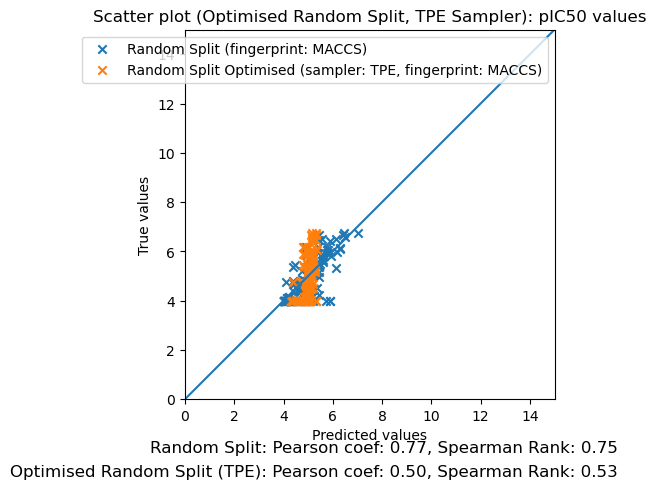

In [27]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred_rfr_rand_MACCS, y_test_rand, marker="x", label="Random Split (fingerprint: MACCS)")
ax.scatter(y_pred_rfr_rand_best_TPE_MACCS, y_test_rand, marker="x", label="Random Split Optimised (sampler: TPE, fingerprint: MACCS)")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot (Optimised Random Split, TPE Sampler): pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)

pearsoncoef_rfr_rand_best_TPE= np.corrcoef(y_pred_rfr_rand_best_TPE_MACCS.flatten(), y_test_rand.values.flatten())[0,1]
spearmancoef_rfr_rand_best_TPE = spearmanr(y_pred_rfr_rand_best_TPE_MACCS.flatten(), y_test_rand.values.flatten()).correlation
pearsoncoef_rfr_rand = np.corrcoef(y_pred_rfr_rand_MACCS.flatten(), y_test_rand.values.flatten())[0,1]
spearmancoef_rfr_rand = spearmanr(y_pred_rfr_rand_MACCS.flatten(), y_test_rand.values.flatten()).correlation
fig.text(0.9, 0, f"Random Split: Pearson coef: {pearsoncoef_rfr_rand:.2f}, Spearman Rank: {spearmancoef_rfr_rand:.2f}", horizontalalignment='right', fontsize=12)
fig.text(0.9, -0.05, f"Optimised Random Split (TPE): Pearson coef: {pearsoncoef_rfr_rand_best_TPE:.2f}, Spearman Rank: {spearmancoef_rfr_rand_best_TPE:.2f}", horizontalalignment='right', fontsize=12)

fig.savefig(DATA / "scatter_plot_rfr_TPE.png")
ax.legend()
plt.show();

In [28]:
# # Scatter plot
# limits = 0, 15
# fig, ax = plt.subplots()
# ax.scatter(y_pred_rfr_rand_best_TPE_MACCS, y_test_rand, marker="x", label="Random Split Optimised (sampler: TPE, fingerprint: MACCS)")
# ax.scatter(y_pred_rfr_rand_best_TPE_m2, y_test_rand_m2, marker="x", label="Random Split Optimised (sampler: TPE, fingerprint: Morgan2)")
# lin = np.linspace(*limits, 100)
# ax.plot(lin, lin)
# ax.set_aspect("equal", adjustable="box")
# ax.set_xlabel("Predicted values")
# ax.set_ylabel("True values")
# ax.set_title("Scatter plot (Optimised Random Split, TPE Sampler): pIC50 values")
# ax.set_xlim(limits)
# ax.set_ylim(limits)

# pearsoncoef_rfr_rand_best_TPE_MACCS = np.corrcoef(y_pred_rfr_rand_best_TPE_MACCS.flatten(), y_test_rand.values.flatten())[0,1]
# spearmancoef_rfr_rand_best_TPE_MACCS = spearmanr(y_pred_rfr_rand_best_TPE_MACCS.flatten(), y_test_rand.values.flatten()).correlation
# pearsoncoef_rfr_rand_best_TPE_m2 = np.corrcoef(y_pred_rfr_rand_best_TPE_m2.flatten(), y_test_rand_m2.values.flatten())[0,1]
# spearmancoef_rfr_rand_best_TPE_m2 = spearmanr(y_pred_rfr_rand_best_TPE_m2.flatten(), y_test_rand_m2.values.flatten()).correlation
# fig.text(0.9, 0, f"Optimised Random Split (TPE, MACCS): Pearson coef: {pearsoncoef_rfr_rand_best_TPE_MACCS:.2f}, Spearman Rank: {spearmancoef_rfr_rand_best_TPE_MACCS:.2f}", horizontalalignment='right', fontsize=12)
# fig.text(0.9, -0.05, f"Optimised Random Split (TPE, Morgan2): Pearson coef: {pearsoncoef_rfr_rand_best_TPE_m2:.2f}, Spearman Rank: {spearmancoef_rfr_rand_best_TPE_m2:.2f}", horizontalalignment='right', fontsize=12)

# fig.savefig(DATA / "scatter_plot_rfr_TPE_rand.png")
# ax.legend()
# plt.show();

In [29]:
# # Scatter plot
# limits = 0, 15
# fig, ax = plt.subplots()
# ax.scatter(y_pred_rfr_fur, y_test_fur, marker="x", label="UMAP Furthest Cluster Split")
# ax.scatter(y_pred_rfr_fur_best, y_test_fur, marker="x", label="UMAP Furthest Split Optimised (sampler: TPE)")
# lin = np.linspace(*limits, 100)
# ax.plot(lin, lin)
# ax.set_aspect("equal", adjustable="box")
# ax.set_xlabel("Predicted values")
# ax.set_ylabel("True values")
# ax.set_title("Scatter plot (Optimised UMAP Furthest Cluster Split, TPE Sampler): pIC50 values")
# ax.set_xlim(limits)
# ax.set_ylim(limits)

# pearsoncoef_rfr_fur_best_TPE = np.corrcoef(y_pred_rfr_fur_best.flatten(), y_test_fur.values.flatten())[0,1]
# spearmancoef_rfr_fur_best_TPE = spearmanr(y_pred_rfr_fur_best.flatten(), y_test_fur.values.flatten()).correlation
# pearsoncoef_rfr_fur = np.corrcoef(y_pred_rfr_rand.flatten(), y_test_rand.values.flatten())[0,1]
# spearmancoef_rfr_fur = spearmanr(y_pred_rfr_fur.flatten(), y_test_fur.values.flatten()).correlation
# fig.text(0.9, 0, f"Random Split: Pearson coef: {pearsoncoef_rfr_fur:.2f}, Spearman Rank: {spearmancoef_rfr_fur:.2f}", horizontalalignment='right', fontsize=12)
# fig.text(0.9, -0.05, f"Optimised Random Split (TPE): Pearson coef: {pearsoncoef_rfr_fur_best_TPE:.2f}, Spearman Rank: {spearmancoef_rfr_fur_best_TPE:.2f}", horizontalalignment='right', fontsize=12)

# fig.savefig(DATA / "scatter_plot_rfr_fur_TPE.png")
# ax.legend()
# plt.show();

In [30]:
# optuna.visualization.plot_optimization_history(study_rand)
# optuna.visualization.plot_parallel_coordinate(study_rand)
# optuna.visualization.plot_slice(study_rand, params=["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"])
# optuna.visualization.plot_param_importances(study_rand)